# Porto Seguro’s Safe Driver Prediction

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this analysis, we will be building a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

## Table of Contents:
1. [Data Quality Checks](#dqc)<br>
    1.1   [Feature Categorization](#ftrcat)<br>
    1.2   [Missing Value Analysis](#missing)<br>
    1.3   [Missing Value Imputation](#impute)
2. [Data Exploration](#de)<br>
    2.1   [Correlation Plot](#corplot)<br>
    2.2   [Explore Target Variable](#exptarget)<br>
    2.3   [Explore Categorical Variable](#expcat)<br>
    2.4   [Explore Binary Variable](#expbin)<br>
3. [Data Preprocessing](#dp)<br>
    3.1   [Target Mean Encoding](#tm)<br>
    3.2   [Normalizing Numerical Features](#norm)<br>
    3.3   [Feature Encoding](#ftrencode)<br>
    3.4   [Shuffle and Split](#shuffle)
4. [Model Evaluation](#me)
5. [Model Selection](#ms)
6. [Model Development](#md)<br>
    6.1   [Model Tuning using RandomizedSearchCV](#mt)
7. [Feature Selection](#fs)<br>
    7.1   [Reduced Feature Space](#reduced)<br>
    7.2   [Benchmarking](#bench)
8. [Conclusion](#conclu)

## Data Quality Checks
<a id = "dqc"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import Imputer
from time import time

%matplotlib inline

In [2]:
## Global parameters declaration
RANDOM_STATE = 32

In [3]:
## Read the traning CSV file 
train_raw = pd.read_csv("Data/train.csv")

In [4]:
print("There are {} rows and {} columns in train dataset".format(train_raw.shape[0],train_raw.shape[1]))

There are 595212 rows and 59 columns in train dataset


<a id = "ftrcat"></a>
### Feature Categorization

In [5]:
## In this code chunk we will analyze the different feature types provided in the dataset

train_copy = train_raw

bin_features = []
cat_features = []
num_features = []
ordinal_features = []

    
for featr in train_copy.columns:
    if "bin" in featr or featr == 'target':
        bin_features.append(featr)
    elif "cat" in featr:
        cat_features.append(featr)
    elif train_copy[featr].dtype == float:
        num_features.append(featr)
    elif train_copy[featr].dtype == int:
        ordinal_features.append(featr)
    else:
        print("Couldn't store it anywhere")
    

        
print("There are {} number of binary features in train dataset".format(len(bin_features)))
print("There are {} number of categorical features in train dataset".format(len(cat_features)))
print("There are {} number of numerical features in train dataset".format(len(num_features)))
print("There are {} number of ordinal features in train dataset".format(len(ordinal_features)))

There are 18 number of binary features in train dataset
There are 14 number of categorical features in train dataset
There are 10 number of numerical features in train dataset
There are 17 number of ordinal features in train dataset


In [6]:

car_features = []
reg_features = []
ind_features = []
calc_features = []
remaining_features = []


for featr in train_copy.columns:
    if "car" in featr:
        car_features.append(featr)
    elif "reg" in featr:
        reg_features.append(featr)
    elif "ind" in featr:
        ind_features.append(featr)
    elif "calc" in featr:
        calc_features.append(featr)
    else:
        remaining_features.append(featr)

        
print("There are {} number of 'car' groupped features in train dataset".format(len(car_features)))
print("There are {} number of 'reg' groupped features in train dataset".format(len(reg_features)))
print("There are {} number of 'ind' groupped features in train dataset".format(len(ind_features)))
print("There are {} number of 'calc' groupped features in train dataset".format(len(calc_features)))
print("There are {} number of remaining features in train dataset".format(len(remaining_features)))

There are 16 number of 'car' groupped features in train dataset
There are 3 number of 'reg' groupped features in train dataset
There are 18 number of 'ind' groupped features in train dataset
There are 20 number of 'calc' groupped features in train dataset
There are 2 number of remaining features in train dataset


<a id = "missing"></a>
### Missing Value Analysis

In [7]:
train_raw.isnull().any().any()

False

In [8]:
## We see False above because the missing values has been replaced by -1 by default. 
## Let's replace -1 by NaN and treat the missing values correctly
train_copy = train_copy.replace(-1,np.NaN)

In [9]:
train_copy.isnull().any().any()

True

In [10]:
## Get the list of feature names along with the count of missing records for each feature

list_null_num = len(train_copy.index) - train_copy.count()
list_null_perc = ((len(train_copy.index) - train_copy.count()) / train_copy.shape[0]) * 100
list_null_num = list_null_num.sort_values(ascending=False)
list_null_perc = list_null_perc.sort_values(ascending=False)

missing_df = pd.DataFrame({'Missing Count':list_null_num,
                             'Missing Percentage(%)':list_null_perc})
missing_df.index.name = 'Feature Names'
missing_df.reset_index(inplace=True)

In [11]:
missing_df[missing_df['Missing Count'] > 0]

,Feature Names,Missing Count,Missing Percentage(%)
0,ps_car_03_cat,411231,69.089837
1,ps_car_05_cat,266551,44.782531
2,ps_reg_03,107772,18.106490
3,ps_car_14,42620,7.160474
4,ps_car_07_cat,11489,1.930237
5,ps_ind_05_cat,5809,0.975955
6,ps_car_09_cat,569,0.095596
7,ps_ind_02_cat,216,0.036290
8,ps_car_01_cat,107,0.017977
9,ps_ind_04_cat,83,0.013945


[<matplotlib.text.Text at 0x109895d30>, <matplotlib.text.Text at 0x10987d4e0>]

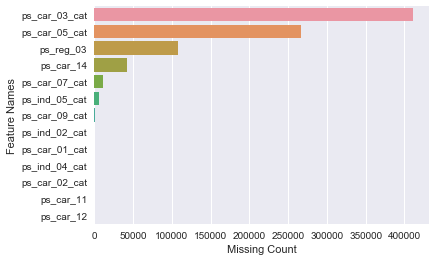

In [12]:
## Bar chart for analyzing the count of missing records for the features with missing values

ax = sns.set(style="darkgrid", color_codes=True)
ax = sns.barplot(x= 'Missing Count', y='Feature Names',data=missing_df[missing_df['Missing Count']>0])
ax.set(xlabel = "Missing Count", ylabel = "Feature Names")

There are in total 13 variables out of 59 which has missing values. <br>
From the above table and the bar chart we have below observations - 
1. **ps_car_03_cat** (68%) and **ps_car_05_cat** (45%) columns has most number of missing values. We will be removing these two columns from our dataset as they won't contribute much towards predictions.
2. **ps_reg_03**, **ps_car_14** and **ps_car_12** are all continuos variable. We will replace the missing values by mean for these columns. 
3. **ps_car_11** has only 5 unique values which means it is a ordinal variable. We can replace the missing values with mode.
4. Rest all are categorical features with less 2% missing values. We can replace these missing values by mode of that columns. But let's develop the model and first with the missing values and see how the model perform. We can take a decision based on the model's performence

<a id = "impute"></a>
### Missing Value Imputation

In [13]:
### Below code will imputer the missing values for few of the columns


## Initializing the imputer 
imp_mean = Imputer(missing_values= 'NaN', strategy= 'mean', axis= 0)
imp_most_frequent = Imputer(missing_values= 'NaN', strategy= 'most_frequent', axis= 0)

## Fit and transform the data using the Imputers above
train_copy['ps_reg_03'] = imp_mean.fit_transform(train_copy[['ps_reg_03']])
train_copy['ps_car_14'] = imp_mean.fit_transform(train_copy[['ps_car_14']])
train_copy['ps_car_12'] = imp_mean.fit_transform(train_copy[['ps_car_12']])

train_copy['ps_car_11'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_11']])).astype(int)
train_copy['ps_car_07_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_07_cat']])).astype(int)
train_copy['ps_ind_05_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_ind_05_cat']])).astype(int)
train_copy['ps_car_09_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_09_cat']])).astype(int)
train_copy['ps_ind_02_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_ind_02_cat']])).astype(int)
train_copy['ps_car_01_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_01_cat']])).astype(int)
train_copy['ps_ind_04_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_ind_04_cat']])).astype(int)
train_copy['ps_car_02_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_02_cat']])).astype(int)


### Let's drop the 2 features with mostly missing values in them

train_copy.drop(['ps_car_03_cat','ps_car_05_cat'],axis=1,inplace=True)

## Remove these features from our categorical feature list as well. 

cat_features.remove('ps_car_03_cat')
cat_features.remove('ps_car_05_cat')

In [14]:
print("After this initial data preprocessing, now we have {} number of rows and {} number of features".format(train_copy.shape[0],train_copy.shape[1]))

After this initial data preprocessing, now we have 595212 number of rows and 57 number of features


In [15]:
train_copy.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


<a id = "de"></a>
## Data Exploration

<a id = "corplot"></a>
### Correlation Plot

In [16]:
## As all the features in the given dataset are numbers, we will check how many are integers and float
## Create temporary dataframes containing only float and integer features for thr purpose of coretlation plot

train_float = train_copy.select_dtypes(include=['float64'])
train_int = train_copy.select_dtypes(include=['int64'])
Counter(train_copy.dtypes.values)

Counter({dtype('int64'): 47, dtype('float64'): 10})

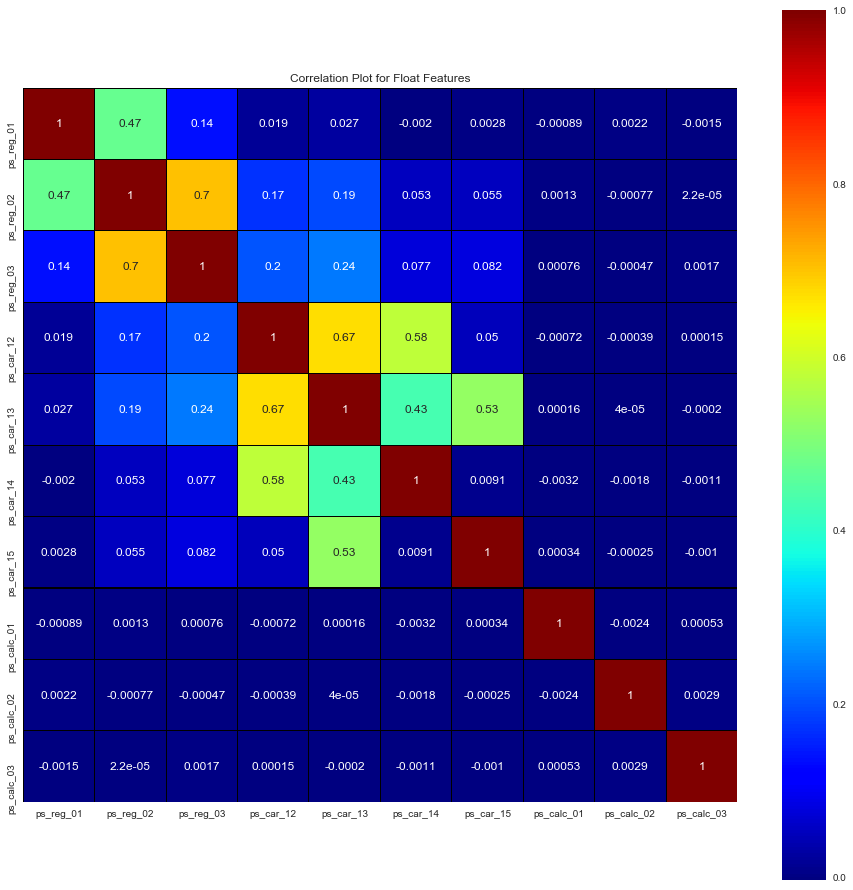

In [17]:
## Correlstion plot for all float Features
ax = plt.figure(figsize=(16,16))
ax = sns.heatmap(train_float.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet, annot= True)
ax.set_title("Correlation Plot for Float Features")
plt.show()
plt.close()

From the above correlation plot we have following observations - 
 1. ps_reg_02 is highly correlated to ps_reg_01 and ps_reg_03
 2. ps_car_13 is highly correlated to ps_car_12,ps_car_14 and ps_car_15
 3. ps_car_14 is corrleated to ps_car_12
<br>
As you can see ps_calc_01 - ps_calc_03 are not correlated to any of the other features.

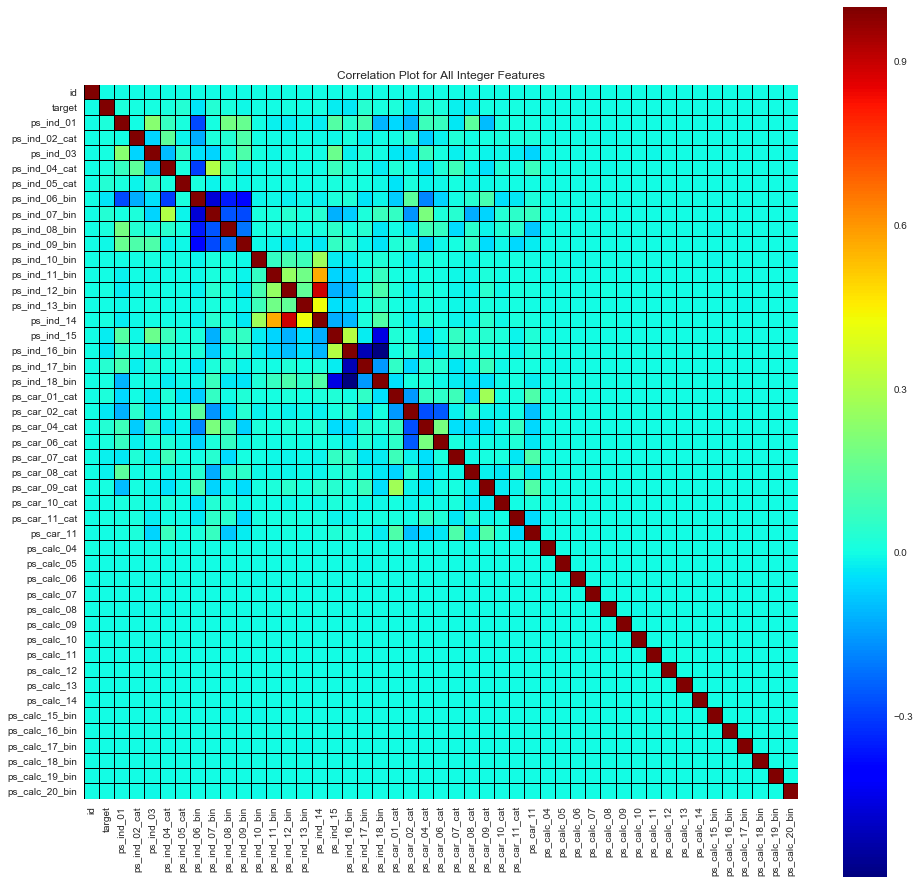

In [18]:
## Correlstion plot for all integer Features

ax = plt.figure(figsize=(16,16))
ax = sns.heatmap(train_int.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet)
ax.set_title("Correlation Plot for All Integer Features")
plt.show()
plt.close()

From the correlation plot of integer features in our dataset, we can see that Features ps_calc_04 till ps_calc_20_bin are not correlated (either positive or negative) to any of the other features in the data. We are not going to remove these fields from our analysis just yet as based on the model we will choose to tune can handle such cases

<a id = "exptarget"></a>
### Explore Target Variable 

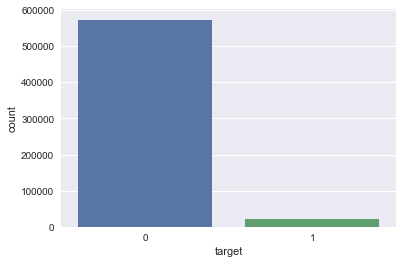

In [19]:
ax = sns.set(style="darkgrid", color_codes=True)
ax = sns.countplot(train_copy['target'])

As we can see in the plot above very few claims were filed.

<a id = "expcat"></a>
### Explore Categorical Variable

### Checking cardinality of Categorical feature

In [20]:
for featr in cat_features:
    print("Variable {} has {} unique values".format(featr,train_copy[featr].value_counts().shape[0]))

Variable ps_ind_02_cat has 4 unique values
Variable ps_ind_04_cat has 2 unique values
Variable ps_ind_05_cat has 7 unique values
Variable ps_car_01_cat has 12 unique values
Variable ps_car_02_cat has 2 unique values
Variable ps_car_04_cat has 10 unique values
Variable ps_car_06_cat has 18 unique values
Variable ps_car_07_cat has 2 unique values
Variable ps_car_08_cat has 2 unique values
Variable ps_car_09_cat has 5 unique values
Variable ps_car_10_cat has 3 unique values
Variable ps_car_11_cat has 104 unique values


For 11 out of 12 categorical features we have less than 20 unique values, so we can create dummy variables for these 11 categorical values <br>
For remaning one categorical feature with high cardinality, we will use target statistics encoding technique later in the analysis

In [21]:
cat_features_temp =  list(cat_features)
cat_features_temp.remove('ps_car_11_cat')

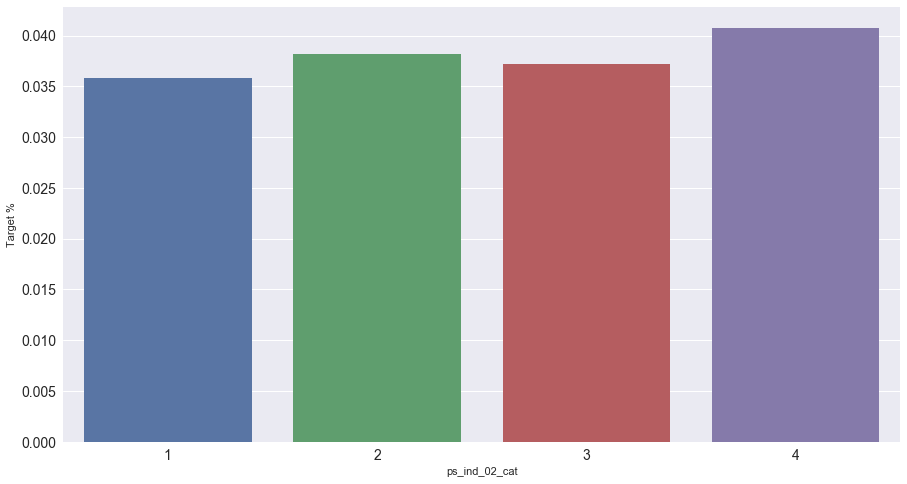

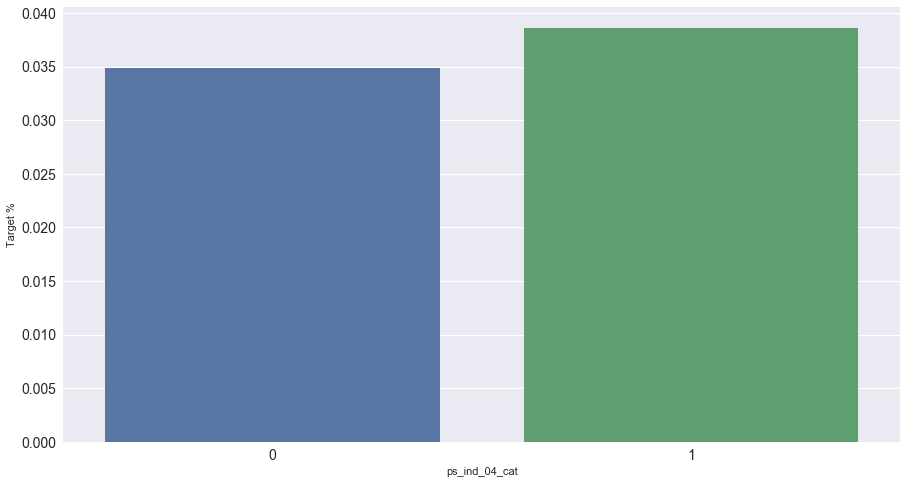

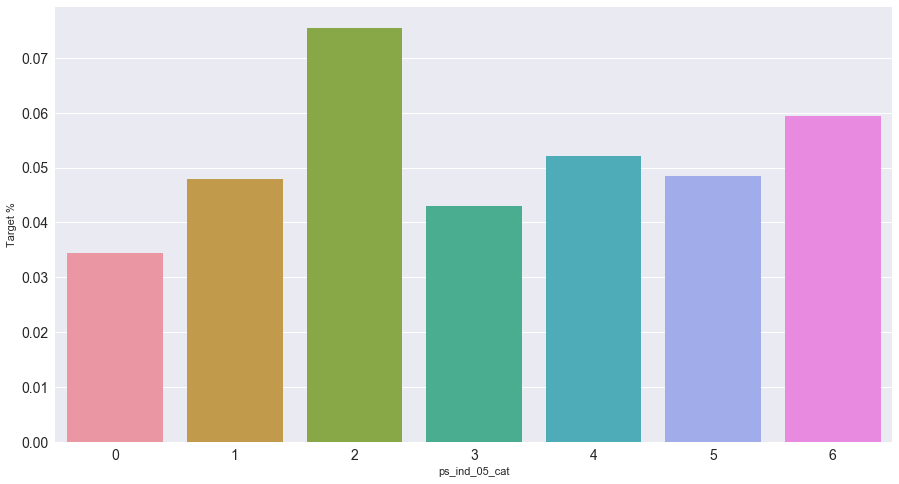

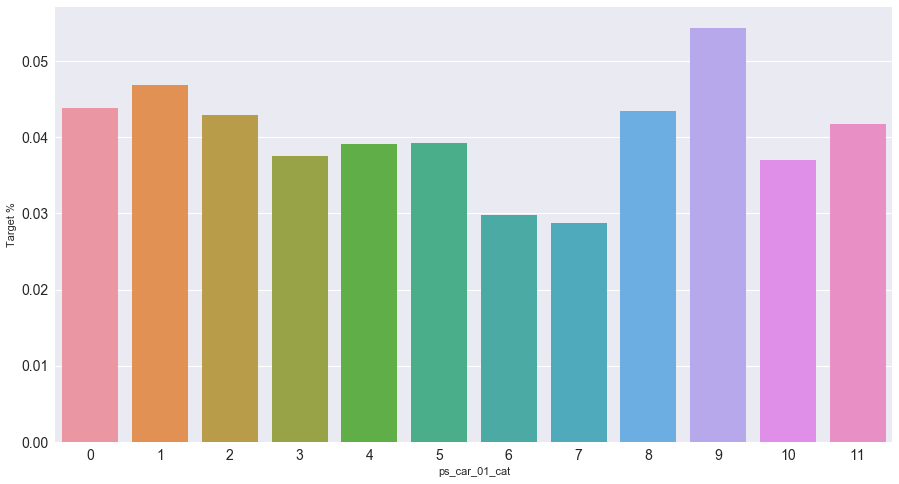

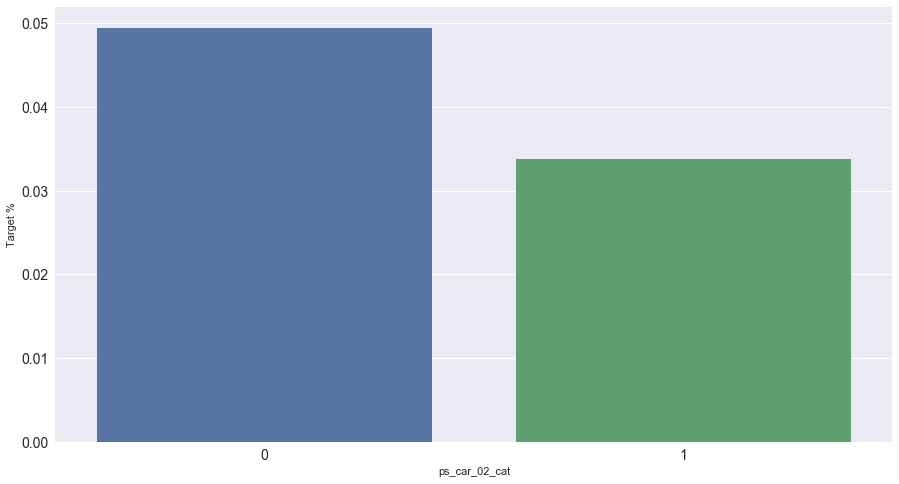

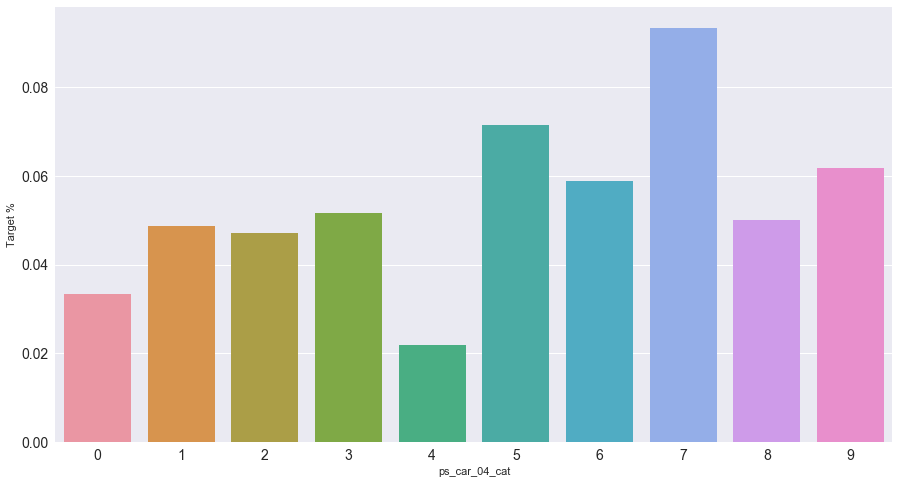

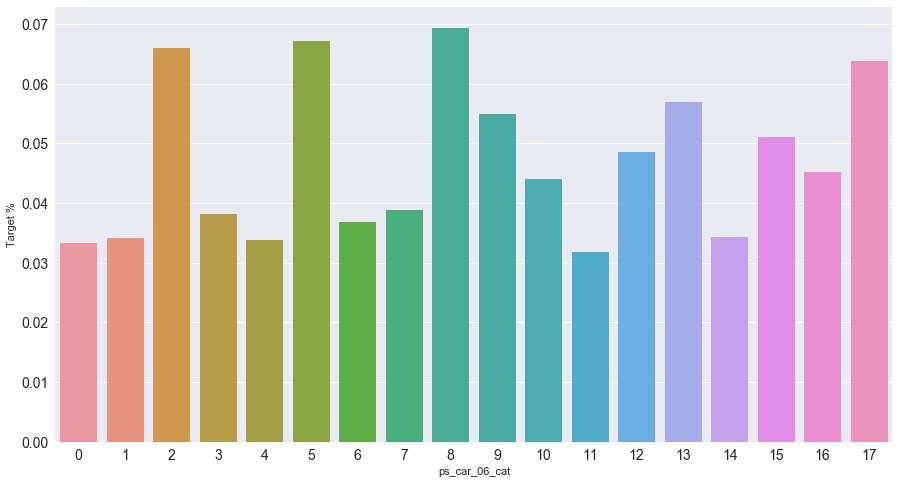

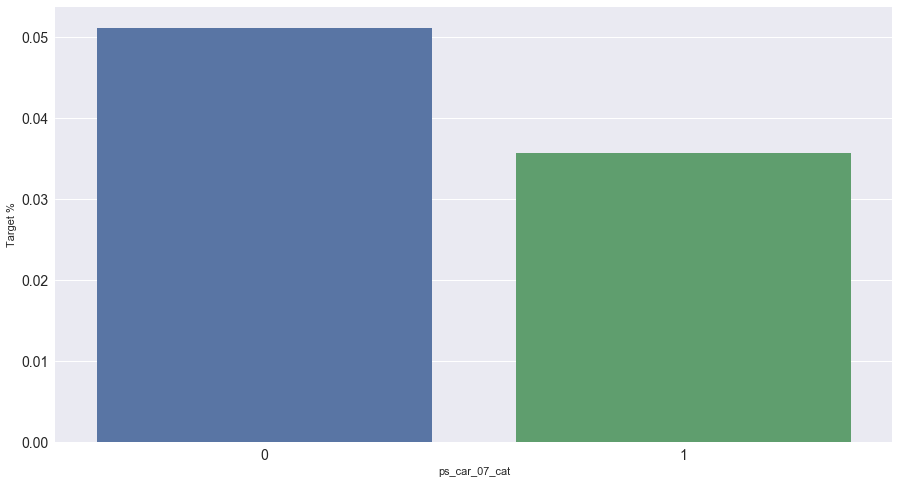

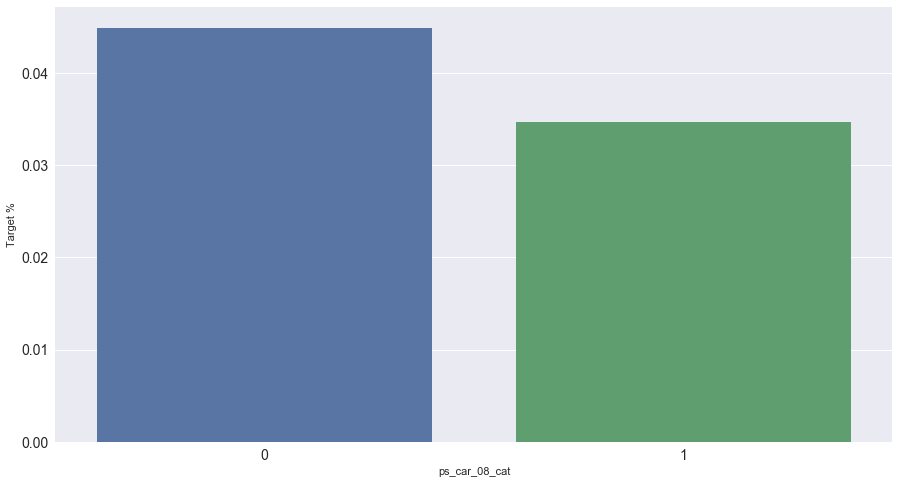

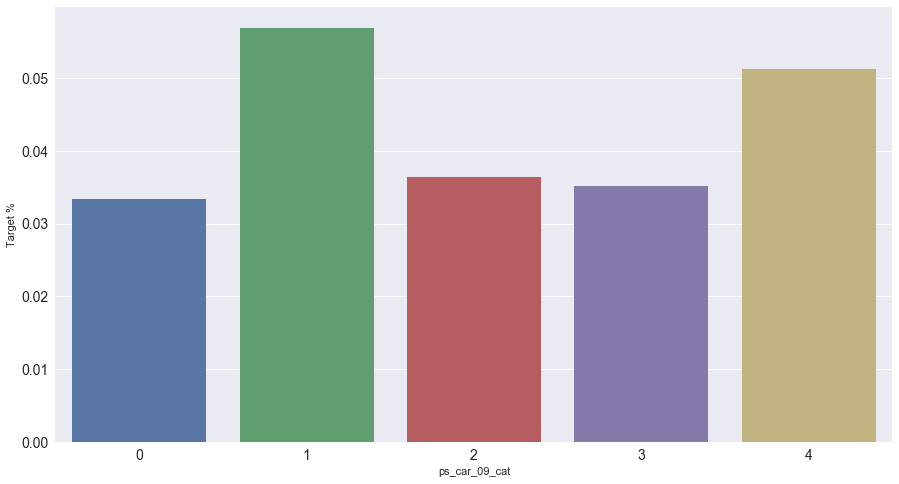

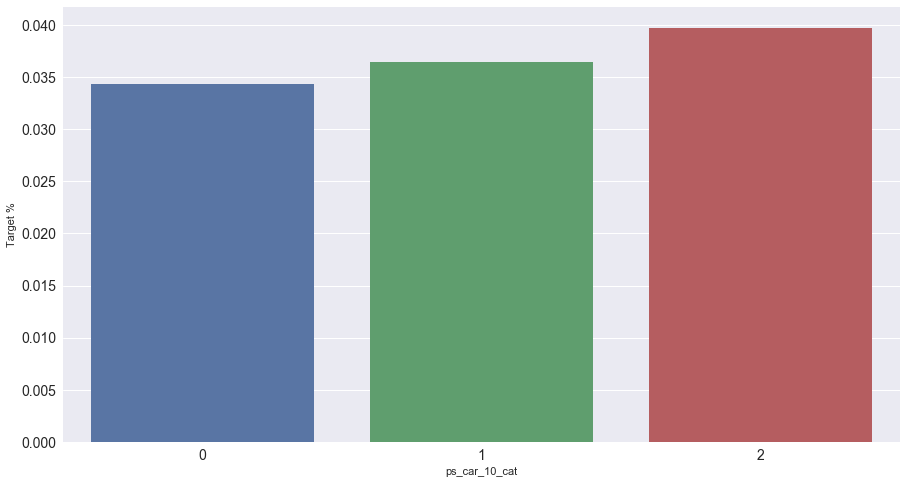

In [22]:
## Let's look into the categorical variables and the proportion of customers with target = 1

for cat_featr in cat_features_temp:
    plt.figure()
    fig= plt.subplots(figsize=(15,8))
    temp_data = train_copy[[cat_featr,'target']].groupby(cat_featr,as_index = False).mean().sort_values('target')
    sns.barplot(x=cat_featr,y='target',data=temp_data)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel("Target %")
    plt.show()
    plt.close()

From the above analysis we can see that there are couple of categorical variables which actually are binary variables.
We will move these 4 features from Categorical list to Binary feature list

In [23]:
features_to_move = ['ps_ind_04_cat','ps_car_02_cat','ps_car_07_cat','ps_car_08_cat']

In [24]:
cat_features = [x for x in cat_features if x not in features_to_move]

In [25]:
bin_features.append('ps_ind_04_cat')
bin_features.append('ps_car_02_cat')
bin_features.append('ps_car_07_cat')
bin_features.append('ps_car_08_cat')

<a id = "expbin"></a>
### Explore Binary Variable

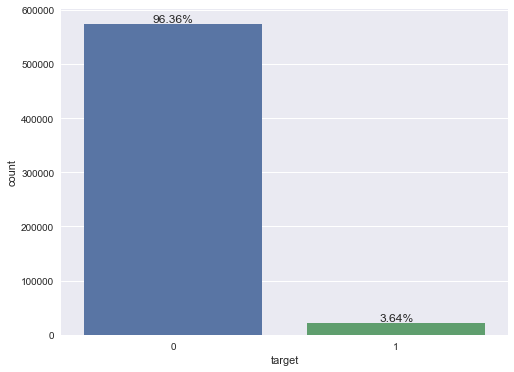

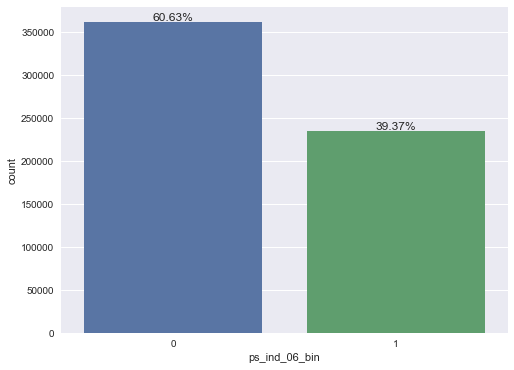

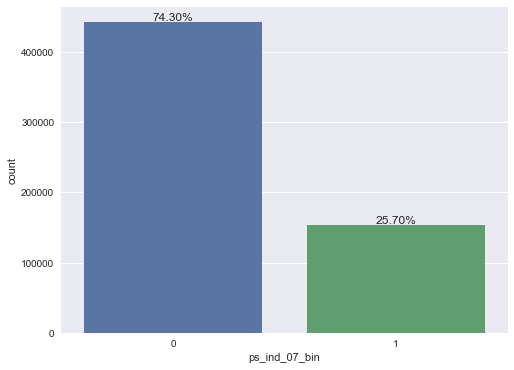

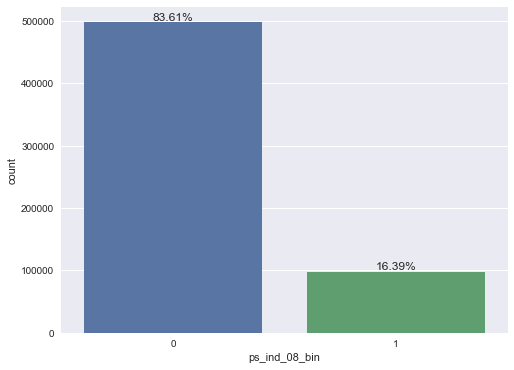

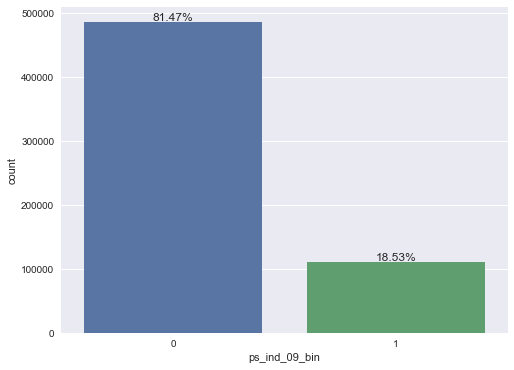

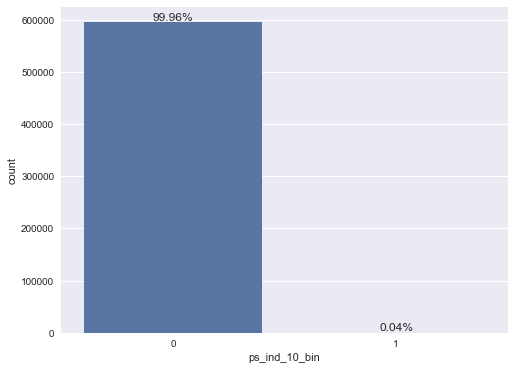

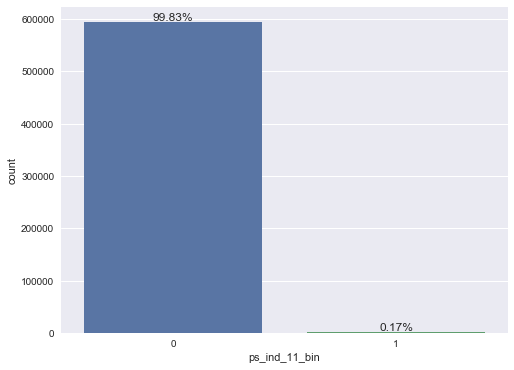

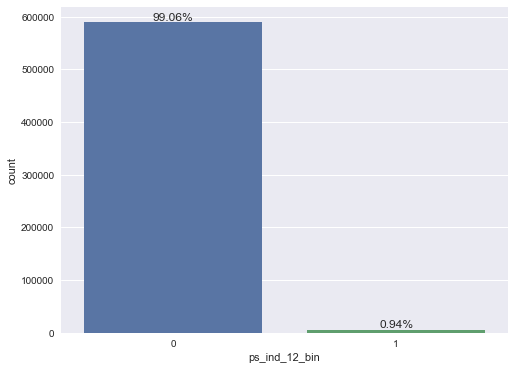

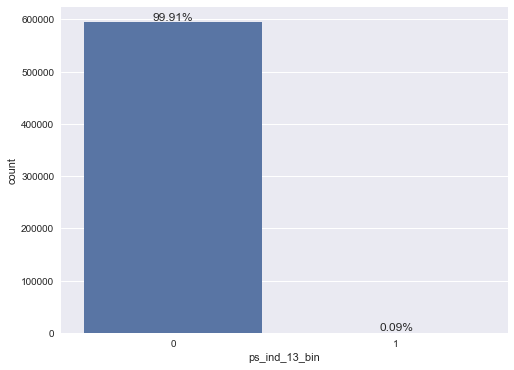

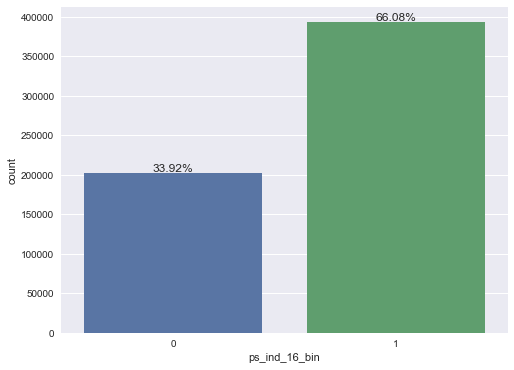

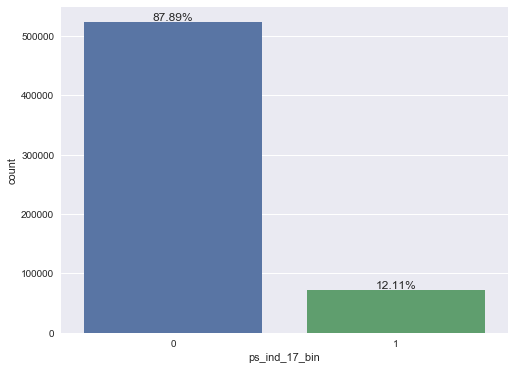

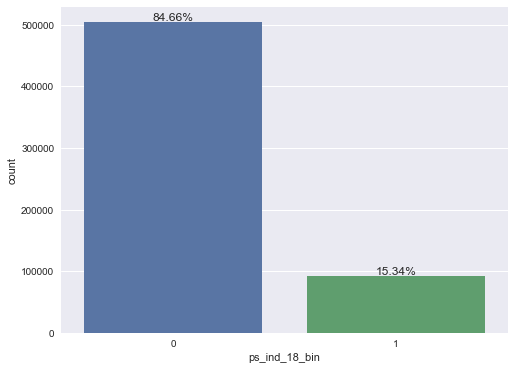

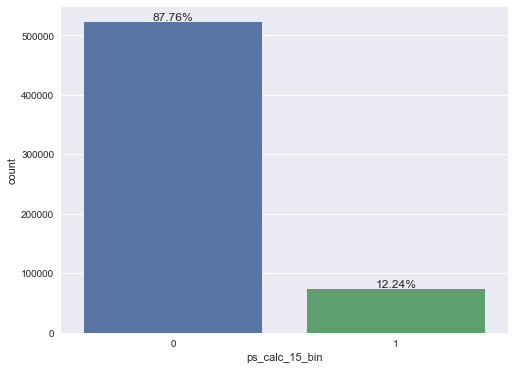

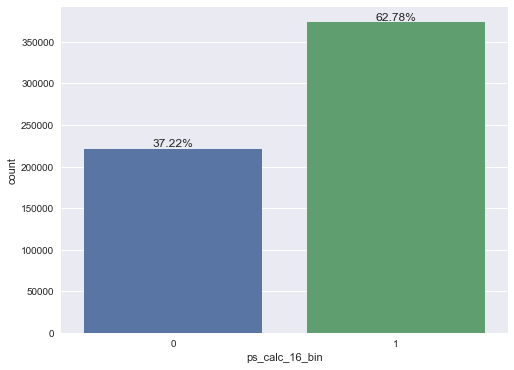

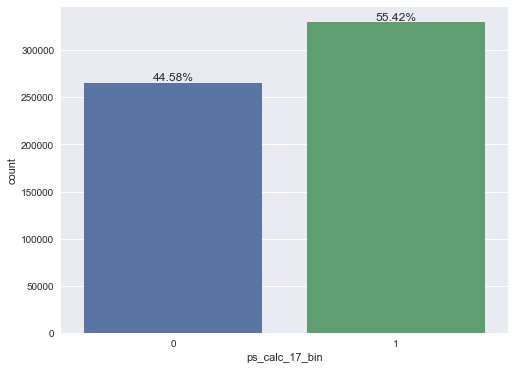

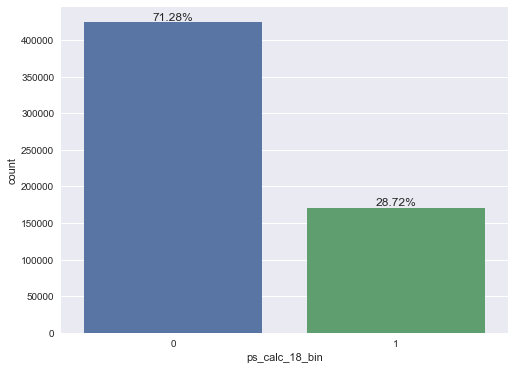

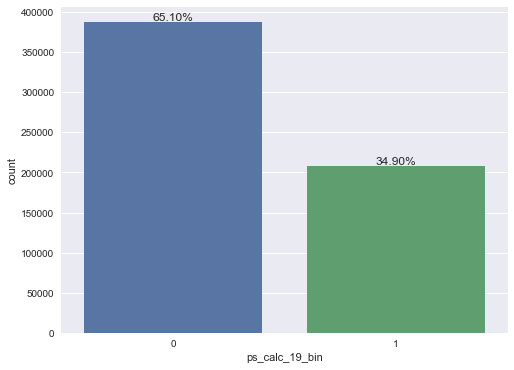

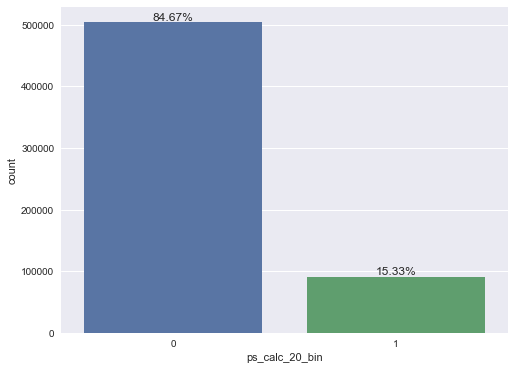

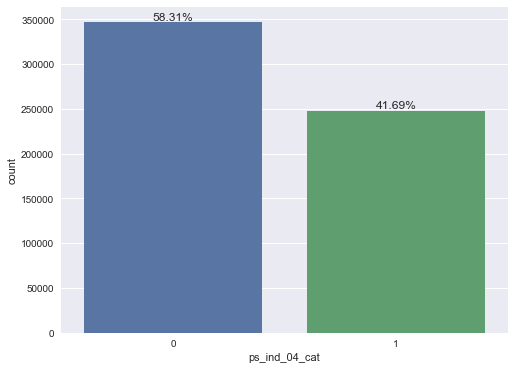

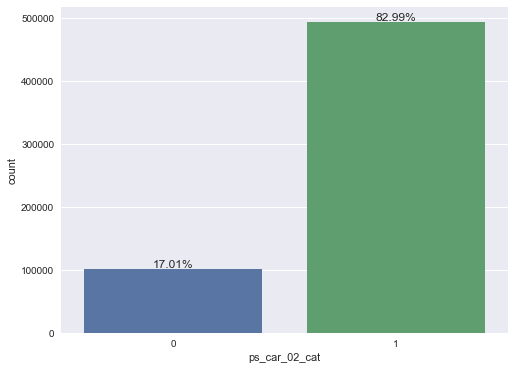

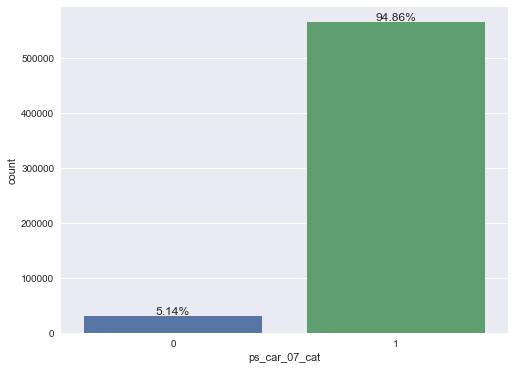

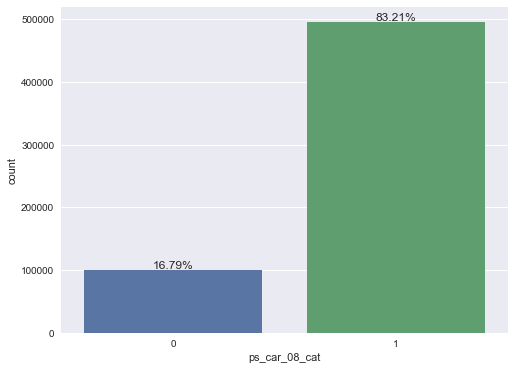

In [26]:
for bin_featr in bin_features:
    plt.figure()
    fig= plt.subplots(figsize=(8,6))
    sns.set(style="darkgrid")
    ax = sns.countplot(x=bin_featr, data= train_copy)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format((height/(float(len(train_copy))))*100),
                ha="center",va="bottom") 
    plt.show()
    plt.close()

We can see from above analysis that ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin have only one value (1). We will remove these columns from our analysis as they won't contribute much towards predictive model. 

In [27]:
## Dropiing the columns those we discussed above from training dataset
train_copy = train_copy.drop(['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin'],axis=1)

## Removing these features from the feature list of binary variables
bin_features = [x for x in bin_features if x not in ['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin']]

In [28]:
print("New Shape of Training data is {}".format(train_copy.shape))

New Shape of Training data is (595212, 53)


<a id = "dp"></a>
## Data Preprocessing

<a id = "tm"></a>
### Target Mean Encoding

Only ps_car_11_cat has many distinct values. To avoid having many dummy variables later on and introducing the curse of dimensionality, we could replace the values in this variable by the supervised ratio. Other strategies to transform this variable are explained in an [article on KDNuggets](http://www.kdnuggets.com/2016/08/include-high-cardinality-attributes-predictive-model.html). We will replace the column with ps_car_11_cat_tm (target mean)

In [29]:
## Supervised Ratio encoding for high cardinality feature

cat_perc = train_copy[['ps_car_11_cat', 'target']].groupby(['ps_car_11_cat'],as_index=False).mean()
cat_perc.rename(columns={'target': 'ps_car_11_cat_tm'}, inplace=True)
train_copy = pd.merge(train_copy, cat_perc, how='inner', on='ps_car_11_cat')
train_copy.drop('ps_car_11_cat', axis=1, inplace=True)

In [30]:
# ## Removing it from the categorical feature names list
cat_features.remove('ps_car_11_cat')
num_features.append('ps_car_11_cat_tm')

In [31]:
print("There are {} number of binary features in train dataset".format(len(bin_features)))
print("There are {} number of categorical features in train dataset".format(len(cat_features)))
print("There are {} number of numerical features in train dataset".format(len(num_features)))
print("There are {} number of ordinal features in train dataset".format(len(ordinal_features)))

There are 18 number of binary features in train dataset
There are 7 number of categorical features in train dataset
There are 11 number of numerical features in train dataset
There are 17 number of ordinal features in train dataset


### Seperate Data into Feature and Target

In [32]:
## Split the data into features and target label

train_target = train_copy['target']
to_drop = ['target','id']
train_features = train_copy.drop(to_drop, axis=1,inplace=False)

<a id = "norm"></a>
### Normalizing Numerical Features

In [33]:
## Normalizing num features
## Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_features[num_features] = scaler.fit_transform(train_features[num_features])

In [34]:
train_features[num_features].head(5)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_car_11_cat_tm
0,0.777778,0.111111,0.165170,0.25753,0.182438,0.495899,0.963624,0.666667,0.555556,0.222222,0.356673
1,0.666667,0.222222,0.162302,0.25753,0.206802,0.408584,1.000000,0.666667,0.555556,0.777778,0.356673
2,1.000000,0.111111,0.141389,0.25753,0.178848,0.495899,0.963624,1.000000,0.000000,0.666667,0.356673
3,1.000000,0.111111,0.137690,0.25753,0.151017,0.495899,0.925820,0.222222,0.666667,0.333333,0.356673
4,0.444444,0.000000,0.141640,0.25753,0.189679,0.495899,1.000000,0.444444,0.000000,0.666667,0.356673


<a id = "ftrencode"></a>
### Encoding Categorical Features

In [35]:
## As we have all the nuerical values in our categorical columns, we are going to create a function which replaces..
## .. the column names with appropriate names containing some part of original column name
def one_hot_encode(df,cat_features_list):
    
    for each_featr in cat_features_list:
        oneHotEncode_temp = pd.get_dummies(df[each_featr])
        new_col_names = ["{}_{}".format(each_featr,x) for x in oneHotEncode_temp.columns]
        oneHotEncode_temp.columns = new_col_names
        df = df.drop(each_featr, axis = 1)
        df = pd.concat([df,oneHotEncode_temp],axis = 1)
    return df
    

In [36]:
train_features_encoded = one_hot_encode(train_features,cat_features)

In [37]:
print("There are {} rows and {} columns in final encoded dataset".format(train_features_encoded.shape[0],train_features_encoded.shape[1]))

There are 595212 rows and 103 columns in final encoded dataset


<a id = "shuffle"></a>
### Shuffle and Split

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [38]:

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features_encoded, train_target, test_size = 0.2, random_state = RANDOM_STATE)

# Show the results of the split
print("Training set has {} rows and {} columns.".format(X_train.shape[0],X_train.shape[1]))
print("Testing set has {} samples and {} columns.".format(X_test.shape[0],X_test.shape[1]))

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training set has 476169 rows and 103 columns.
Testing set has 119043 samples and 103 columns.


<a id = "me"></a>
## Model Evaluation

Model is evaluated using the Normalized Gini Coefficient. <br>

During scoring, observations are sorted from the largest to the smallest predictions. Predictions are only used for ordering observations; therefore, the relative magnitude of the predictions are not used during scoring. The scoring algorithm then compares the cumulative proportion of positive class observations to a theoretical uniform proportion.

The Gini Coefficient ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score. The theoretical maximum for the discrete calculation is (1 - frac_pos) / 2.

The Normalized Gini Coefficient adjusts the score by the theoretical maximum so that the maximum score is 1.

In [39]:
# Compute gini

def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

<a id = "ms"></a>
## Model Selection

We will be selecting one model from the below four models and end up tuning a single model on the training dataset. Here is a brief intoroduction on each classifier we will be testing. <br>

**Naive Bayes:**<br>

One of the best industry application of Naive Bayes algorithm is Spam email filtering. <br>

Due to its simplicity, this algorithm might outperform more complex models when the data set isn’t large enough. 
However, the disadvantage of the model is that it makes a strong assumption about the independence of the features which is why it is called as Naive Classifier. Additionally, this algorithm performs poorly in case the words used are not as relevant as the order in which they’re written.

Naive Bayes is an eager learning classifier, which makes it time efficient when we are working on large datasets. Time efficiency feature of Naive Bayes algorithm makes it a good candidate for our case.

**Random Forest:** <br>

_Pros_ - <br>
 - It is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier.
 - It runs efficiently on large databases.<br>

_Cons_ - <br>
 - Random forests have been observed to overfit for some datasets with noisy classification/regression tasks.
 - Unlike decision trees, the classifications made by random forests are difficult for humans to interpret.
 - For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. 

As random forest produces highly accuracte classifiers on large datasets, it's a good candidate for our problem

**Gradient Boosting:**<br>
Gradient boosting is one of the most powerful techniques for building predictive models. Gradient boosting is a greedy procedure. New decision trees are added to the model to correct the residual error of the existing model. <br>
Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.


**XGB Classifier:**<br>
XGBoost stands for e**X**treme **G**radient **Boost**ing.
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. <br>


XGBoost algorithm has become the ultimate weapon of many data scientist. It’s a highly sophisticated algorithm, powerful enough to deal with all sorts of irregularities of data.<br>
The two reasons to use XGBoost are also the two goals of the project:
     - XGBoost Execution Speed is Really fast when compared to other implementations of gradient boosting.
     - XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problem

#### Implementation - Creating a Training and Predicting Pipeline<br>

To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 


In [215]:

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.model_selection import StratifiedKFold

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict_proba(X_test)[:,1]
    predictions_train = learner.predict_proba(X_train[:300])[:,1]
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
        
    # TODO: Compute accuracy on the first 300 training samples
    results['gini_train'] = eval_gini(y_train[:300],predictions_train)
    
    # TODO: Compute accuracy on test set
    results['gini_test'] = eval_gini(y_test,predictions_test)
    
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [216]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# TODO: Initialize the three models

clf_A = RandomForestClassifier(random_state = RANDOM_STATE)
clf_B = GaussianNB()
clf_C = XGBClassifier(random_state = RANDOM_STATE)
clf_D = GradientBoostingClassifier(random_state=RANDOM_STATE)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train) * 0.01)
samples_10 = int(len(X_train) * 0.1)
samples_100 =int(len(X_train) * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)



RandomForestClassifier trained on 4761 samples.
RandomForestClassifier trained on 47616 samples.
RandomForestClassifier trained on 476169 samples.
GaussianNB trained on 4761 samples.
GaussianNB trained on 47616 samples.
GaussianNB trained on 476169 samples.
XGBClassifier trained on 4761 samples.
XGBClassifier trained on 47616 samples.
XGBClassifier trained on 476169 samples.
GradientBoostingClassifier trained on 4761 samples.
GradientBoostingClassifier trained on 47616 samples.
GradientBoostingClassifier trained on 476169 samples.


In [217]:
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
gini_test,0.059336,0.066148,0.066915
gini_train,1.000000,1.000000,1.000000
pred_time,0.270916,0.447151,0.670857
train_time,0.110398,1.027544,21.148704


GaussianNB


,1%,10%,100%
gini_test,-0.008893,0.202468,0.212384
gini_train,0.453345,0.378081,0.368838
pred_time,0.380687,0.246551,0.219280
train_time,0.017281,0.158433,1.876455


XGBClassifier


,1%,10%,100%
gini_test,0.167632,0.243504,0.265012
gini_train,0.874120,0.542254,0.481954
pred_time,0.527940,0.479469,0.628018
train_time,1.774250,16.955933,198.128723


GradientBoostingClassifier


,1%,10%,100%
gini_test,0.151713,0.243810,0.266788
gini_train,0.912412,0.529930,0.461708
pred_time,0.563831,0.500495,0.549065
train_time,1.353752,15.269200,250.949904


From the above analysis we can see that XGBClassifier and GradientBoosting classifier has a similar accuracy. <br>
But we know that xgboost uses a more regularized model formalization to control over-fitting, which gives it better performance and also has an faster execution speed comared to othet flavors of Gradient Boosting. <br>
As we can see in the table above, that even though accuracy is similar for XGBoost and GBM , without any parameter tuning XGBoost has a better training time.<br>
Considering we have an imbalanced data with more than 500k rows, we will be working with XGboost model. In the coming parts of the analysis, we will be tuning a XGBoost model on the training data that we have.

<a id = "md"></a>
## Model Development

Lets try Developing Gradient Boosting Classifier

<a id = "mt"></a>
### Model Tuning using RandomizedSearchCV

Let's fine tune the chosen model. We will use random search (RandomizedSearchCV) with three parameters to tune. We will need to use the entire training set for this. In the code cell below, we will need to implement the following:
Import sklearn.model_selection.RandomizedSearchCV.
 - Initialize the classifier you've chosen and store it in clf.
     - Set a random_state if one is available to the same state you set before.
 - Create a dictionary of parameters you wish to tune for the chosen model.
     - Example: parameters = {'parameter' : [list of values]}.
 - Fit the grid search object to the training data (X_train, y_train), and store it in grid_fit.

In [159]:
###### TODO: Import 'RandomizedSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


start = time() 
# TODO: Initialize the classifier
clf = XGBClassifier(random_state= RANDOM_STATE)


# TODO: Create the parameters list you wish to tune
parameters = {
                'max_depth' : [4,7],
                'learning_rate': [0.07, 0.09],
                'n_estimators' : [400,600]
             }

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = RandomizedSearchCV(clf, parameters, n_iter=5,cv=4, scoring = 'roc_auc')

# TODO: Fit the grid search object to the training data and find the optimal parameter
grid_fit = grid_obj.fit(X_train,y_train)
end = time()

print("Total time taken is - {} mins".format((end - start)/60))

Total time taken is - 424.9320543130239 mins


In [160]:
# Get the estimator
best_clf = grid_fit.best_estimator_
grid_fit.best_params_

{'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 400}

In [162]:
# Make predictions using the unoptimized and optimized model
predictions_tst_unoptimized = (clf.fit(X_train, y_train)).predict_proba(X_test)[:,1]
predictions_tst = best_clf.predict_proba(X_test)[:,1]

In [163]:
print("Unoptimized model\n------")
print("Gini Index on testing data: {:.4f}".format(eval_gini(y_test, predictions_tst_unoptimized)))

print("\nOptimized Model\n------")
print("Gini Index on the testing data: {:.4f}".format(eval_gini(y_test, predictions_tst)))

Unoptimized model
------
Gini Index on testing data: 0.2650

Optimized Model
------
Gini Index on the testing data: 0.2681


<a id = "fs"></a>
## Feature Selection

In [44]:
## Temp section which you need delete
from xgboost import XGBClassifier

xgb_param = {
                'learning_rate' : 0.07,
                'n_estimators' : 400,
                'max_depth' : 4
            }

# TODO: Initialize the classifier
clf = XGBClassifier(**xgb_param,random_state=RANDOM_STATE)

clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=32, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

An important task when performing supervised learning is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual file an auto insurance claim coming year.<br>
We are going to use the same Xgboost calssifier to get the feature importance. In the next python cell fit this classifier to training set and get the feature importance for all the features.

In [81]:
## We will train our final model based on the best fit parameters we found above through Random search CV. So We ...
## ... will be using the optimized model.

In [45]:
# TODO: Extract the feature importances

#importances = clf.feature_importances_
importances = best_clf.feature_importances_

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_features_encoded.columns, best_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance',ascending=False,inplace=True)
importances.index.name = 'Feature_name'
importances.reset_index(inplace=True)

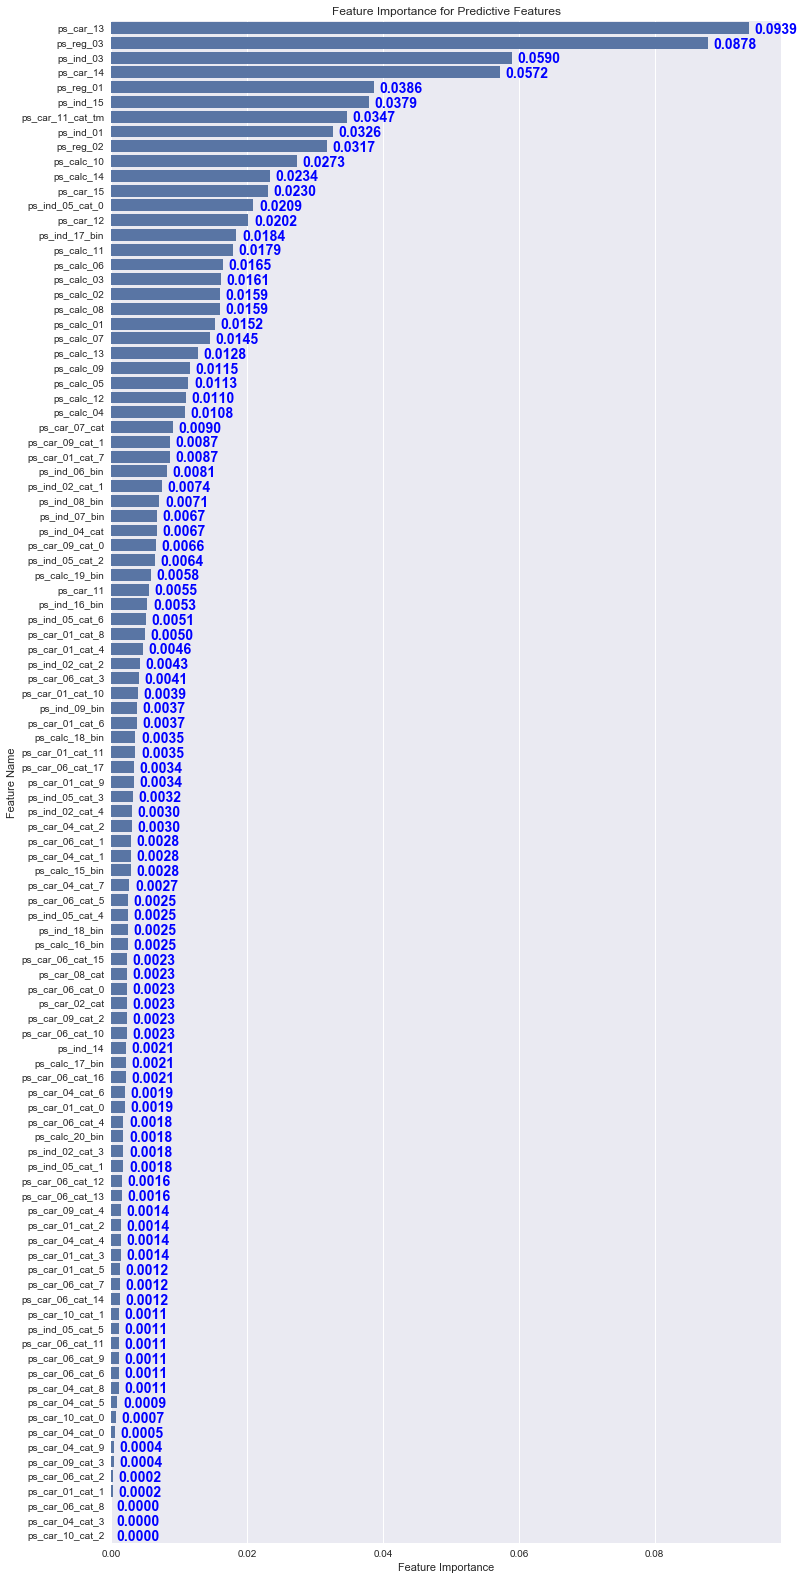

In [46]:
ax = plt.subplots(figsize=(12, 28))
sns.set_style("whitegrid")
ax = sns.barplot(x="feature_importance",y="Feature_name",data=importances, color='b')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Name')
ax.set_title('Feature Importance for Predictive Features')

x = list(importances['feature_importance'])
myFormattedList = [ '%.4f' % elem for elem in x ]
reacts = ax.patches

for re,label in zip(reacts,myFormattedList):
    width = re.get_width()
    ax.text(width+0.004,re.get_y(),str(label),ha="center", va="top",fontsize = 14,fontweight='bold',color = 'blue')
plt.show()

plt.close()

In [47]:
Feature_selected = ((importances[importances['feature_importance'] > 0.0018])['Feature_name'])

<a id = "reduced"></a>
### Reduced Feature Space

In [48]:
# Import functionality for cloning a model
from sklearn.base import clone


X_train_reduced =  X_train[Feature_selected].copy() ## Actual train data
X_test_reduced  = X_test[Feature_selected].copy() ## Test data we have seperated from train data for testing model

# Train on the "best" model found from grid search earlier
#clf = (clone(best_clf)).fit(X_train_reduced, y_train)


In [173]:
print("There are {} rows and {} columns in the full dataset".format(X_train.shape[0],X_train.shape[1]))
print("There are {} rows and {} columns in the reduced dataset".format(X_train_reduced.shape[0],X_train_reduced.shape[1]))

There are 476169 rows and 103 columns in the full dataset
There are 476169 rows and 74 columns in the reduced dataset


By taking the subset of features using Feature Importance based on the optimized trained model, we have reduced our feature space by almost 36%, which helps us to reduce the dimensionality of dataset on which we will be training our model.

In [174]:
# Make new predictions
predictions_tst_ReducedData = clf.predict_proba(X_test_reduced)[:,1]

In [175]:
print("Final Model trained on full data\n------")
print("Gini Index on testing data: {:.4f}".format(eval_gini(y_test, predictions_tst)))

print("\nFinal Model trained on reduced data\n------")
print("Gini Index on the testing data: {:.4f}".format(eval_gini(y_test, predictions_tst_ReducedData)))

Final Model trained on full data
------
Gini Index on testing data: 0.2681

Final Model trained on reduced data
------
Gini Index on the testing data: 0.2689


#### Effects of Feature Selection

Even though we reduced the data dimensionality by almost one third, the accuracy of the model increased a bit. The Gini index for the model has increased to 0.2689 from 0.2681. This means that, by selecting less important features we were able to get rid of some noisy data and improve our model further. Considering the time factor, as the dimensionally reduced data takes considerably less amount of time to build the model,as well asincreased Gini Index we can consider using reduced data as our training set.

Lets take a look at the final Boosting tree generated by XGBoost model we just developed

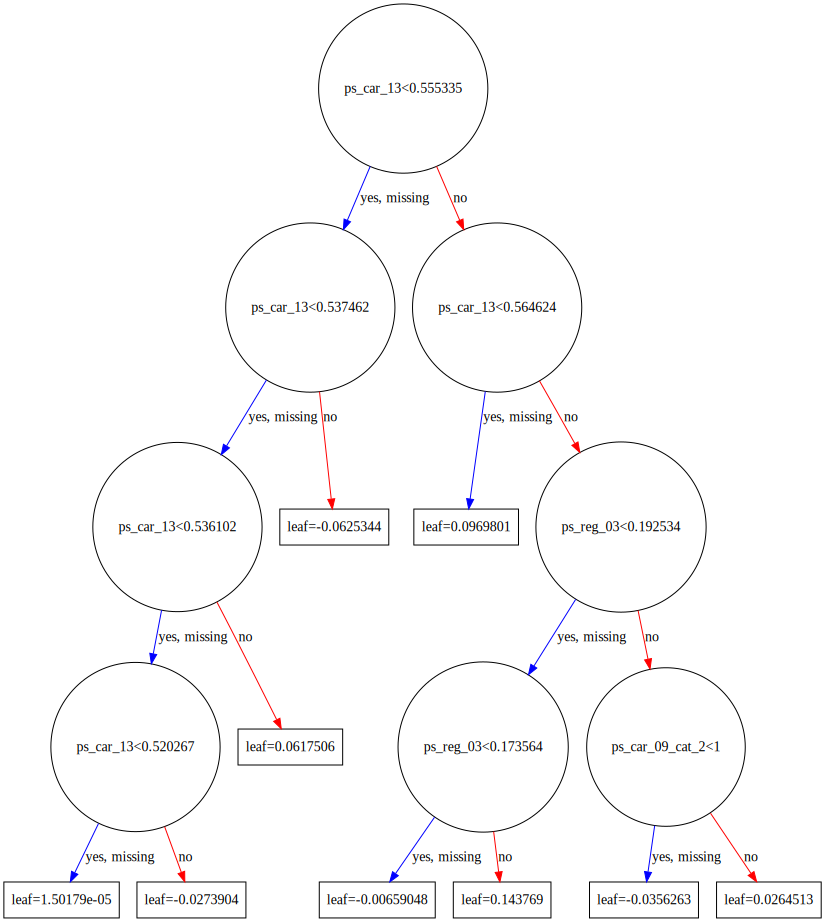

In [266]:
import xgboost as xgb
xgb.to_graphviz(best_clf,num_trees=399)

### Model Evaluation and Validation

In [53]:

from sklearn.model_selection import StratifiedKFold
New_X_train = train_features_encoded[Feature_selected].copy()

xgb_param = {
                'learning_rate' : 0.07,
                'n_estimators' : 400,
                'max_depth' : 4
            }

# TODO: Initialize the classifier
clf = XGBClassifier(**xgb_param)

k_folds = 4
gini_tot = 0

skf = StratifiedKFold(n_splits=k_folds, shuffle = True, random_state = RANDOM_STATE)

for train_index, test_index in skf.split(New_X_train, train_target):
    start_for = time()
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_fold, X_valid = New_X_train.iloc[train_index], New_X_train.iloc[test_index]
    y_train_fold, y_valid = train_target.iloc[train_index], train_target.iloc[test_index]
    
    eval_set=[(X_train_fold,y_train_fold), (X_valid,y_valid)]
    
    clf_fit = clf.fit(X_train_fold,y_train_fold,
                      eval_metric=gini_xgb,
                      eval_set=eval_set,
                      verbose=False)
    # Generate validation predictions for this fold
    pred = clf_fit.predict_proba(X_valid)[:,1]
    gini_fold = eval_gini(y_valid, pred)
    print( "  Gini = ",  gini_fold)
    end_for = time()
    print("Time taken for this fold is {} mins".format((end_for-start_for)/60))
    gini_tot = gini_tot + gini_fold


print("Final average gini score with Validation set is - {}".format(gini_tot/k_folds))


TRAIN: [     0      1      3 ..., 595208 595210 595211] TEST: [     2      4      9 ..., 595203 595204 595209]
  Gini =  0.266278235816
Time taken for this fold is 33.83631953001022 mins
TRAIN: [     0      1      2 ..., 595209 595210 595211] TEST: [     5      7     12 ..., 595194 595205 595208]
  Gini =  0.293906082132
Time taken for this fold is 33.761112515131636 mins
TRAIN: [     0      2      3 ..., 595207 595208 595209] TEST: [     1     16     19 ..., 595206 595210 595211]
  Gini =  0.272248105184
Time taken for this fold is 33.724811951319374 mins
TRAIN: [     1      2      4 ..., 595209 595210 595211] TEST: [     0      3      6 ..., 595196 595197 595207]
  Gini =  0.277805457872
Time taken for this fold is 33.50935138861338 mins
Final average gini score with Validation set is - 0.2775594702510495


<a id = "bench"></a>
### Benchmarking

The benchmark model we are working against is a random forest model gini index. We have a benchmark model performance of Normalized Gini Index at 0.238. Considering, this is a unique dataset and not much research is available on benchmarking in this particular problem area, we checked our Gini index against the provided Random Forest Benchmark.<br>
The fianal gini index of our optimized model is 0.269. So our model passes the benchmark model by a big margin.

<a id = "conclu"></a>
## Conclusion

The model we have developed above can be used by Porto Seguro to identify the driveres which are more likely to file an insurance claim coming year.
A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

One of the speciality of XGBoost alogorithm is, it has a lot of parameters those can be tuned for better performance. To improve the result further we can fine tune the parameters like scale_pos_weight for taking in to consideration the class imbalance. Also, we can tune parameters like reg_alpha & reg_lambda for applying regulerization to handel overfitting. We can also pre process data more to perform data sampling to take care of imbalanced data.